In [1]:
import ast
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator

from scipy.ndimage import uniform_filter1d
import warnings


In [2]:
def extract_roast_data(alog_path, window=30):
    """Extract roast variables from log file."""
    with open(alog_path, "r") as f:
        data = ast.literal_eval(f.read())
    bt = data["temp2"]
    et = data["temp1"]
    comp = data["computed"]
    charge_bt = comp["CHARGE_BT"]
    charge_time = next(i for i, t in enumerate(bt) if t >= charge_bt)
    tp_time = comp["TP_time"] + charge_time + window
    fcs_time = comp["FCs_time"] + charge_time + window
    drop_time = comp["DROP_time"] + charge_time + window
    start = max(charge_time - window, 0)
    end = int(drop_time)
    bt_win = np.array(bt[start:end])
    et_win = np.array(et[start:end])
    time_win = np.arange(start, end) - charge_time
    ror = np.zeros_like(bt_win)
    for i in range(window, len(bt_win)):
        ror[i] = (bt_win[i] - bt_win[i-window]) / window * 60
    ror_sm = uniform_filter1d(ror, size=15)
    return {
        "time": time_win,
        "bt": bt_win,
        "et": et_win,
        "ror": ror_sm,
        "indices": {
            "tp": int(tp_time - charge_time),
            "fcs": int(fcs_time - charge_time),
            "drop": int(drop_time - charge_time),
        },
        "charge_bt": charge_bt,
        "charge_time": charge_time
    }

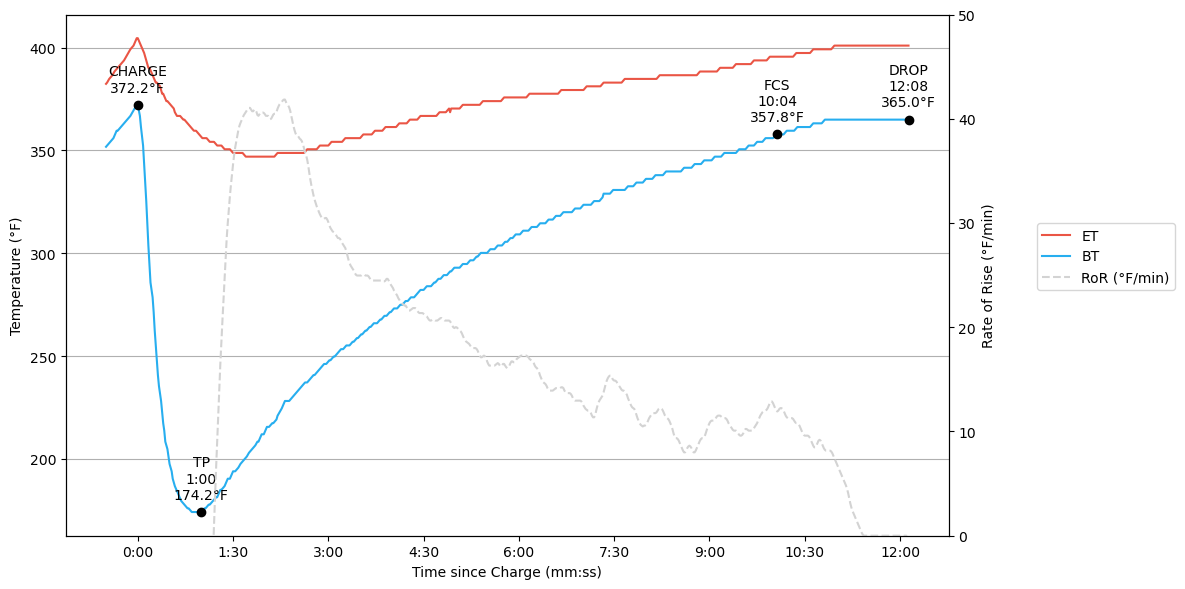

In [3]:
# Plot roast curve with raw ET/BT and RoR between TP and DROP
def plot_roast(data):
    time = np.array(data["time"])
    bt = np.array(data["bt"])
    et = np.array(data["et"])
    ror = np.array(data["ror"])
    idx = data["indices"]
    charge_temp = data["charge_bt"]

    # clamp drop index
    drop_idx = min(idx["drop"], len(time) - 1)

    # trim data to DROP
    t_raw = time[:drop_idx + 1]
    b_raw = bt[:drop_idx + 1]
    e_raw = et[:drop_idx + 1]

    fig, ax1 = plt.subplots(figsize=(12,6))
    # Nicer color palette
    et_color = "#ea5545"      # Bamboozle by Farrow and Ball
    bt_color = "#27aeef"      # Hague Blue by Farrow and Ball

    ax1.plot(t_raw, e_raw, color=et_color, label='ET')
    ax1.plot(t_raw, b_raw, color=bt_color, label='BT')

    # label offset
    label_offset = 5

    # plot and label charge at time zero
    ax1.scatter(0, charge_temp, color='black', zorder=5)
    ax1.text(0, charge_temp + label_offset,
             f"CHARGE\n{charge_temp:.1f}°F",
             ha="center", va="bottom")

    # label TP, FCS, DROP on raw data
    for event in ["tp", "fcs", "drop"]:
        ix = min(idx[event], drop_idx)
        x_evt, y_evt = time[ix], bt[ix]
        ax1.scatter(x_evt, y_evt, color='black', zorder=5)
        ax1.text(x_evt, y_evt + label_offset,
                 f"{event.upper()}\n{int(x_evt//60)}:{int(x_evt%60):02d}\n{y_evt:.1f}°F",
                 ha="center", va="bottom")

    # RoR between TP and DROP
    tp_idx = min(idx["tp"], drop_idx)
    r_time = time[tp_idx:drop_idx+1]
    r_segment = ror[tp_idx:drop_idx+1]
    ax2 = ax1.twinx()
    ax2.plot(r_time, r_segment, linestyle="--", color='lightgray', label="RoR (°F/min)")
    ax2.set_ylabel("Rate of Rise (°F/min)")
    ax2.set_ylim(0, 50)

    # dynamic x-ticks every ~30s
    max_ticks = 10
    interval = ((drop_idx + max_ticks*30 - 1) // (max_ticks*30)) * 30
    ax1.xaxis.set_major_locator(MultipleLocator(interval))
    ax1.xaxis.set_major_formatter(
        FuncFormatter(lambda x, pos: f"{int(x//60)}:{int(x%60):02d}")
    )
    ax1.set_xlabel("Time since Charge (mm:ss)")
    ax1.set_ylabel("Temperature (°F)")

    # legend outside
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left",
               bbox_to_anchor=(1.1, .6), borderaxespad=0)

    # only horizontal gridlines on temperature axis
    ax1.grid(True, axis='y')
    ax1.grid(False, axis='x')
    ax2.grid(False)

    plt.tight_layout()
    plt.show()

# Example usage:
data = extract_roast_data("data/24-12-19_1353.alog")
plot_roast(data)


In [4]:
def load_roast_data_as_dataframe(folder, window=30):
    """
    Load .alog files into a DataFrame, skipping any files with missing
    required fields and reporting which files failed and what was missing.
    """
    rows, failures = [], []
    required_data = ["timex", "temp1", "temp2"]
    required_events = [
        "CHARGE_ET", "CHARGE_BT",
        "TP_time",    "TP_ET",    "TP_BT",
        "DROP_time",  "DROP_ET",  "DROP_BT"
    ]
    for file in Path(folder).glob("*.alog"):
        data   = ast.literal_eval(open(file).read())
        events = data.get("computed", {})
        missing = []
        for key in required_data:
            if key not in data:
                missing.append(key)
        for key in required_events:
            if key not in events:
                missing.append(key)
        if not ("FCs_time" in events or "FCe_time" in events):
            missing.append("FCs_time/FCe_time")
        if not ("FCs_ET" in events or "FCe_ET" in events):
            missing.append("FCs_ET/FCe_ET")
        if not ("FCs_BT" in events or "FCe_BT" in events):
            missing.append("FCs_BT/FCe_BT")
        if missing:
            failures.append((file.name, missing))
            continue  # skip files with missing data

        bt = data["temp2"]
        ror = np.zeros(len(bt))
        for i in range(window, len(bt)):
            ror[i] = (bt[i] - bt[i-window]) / window * 60
        bt_ror = uniform_filter1d(ror, size=15).tolist()

        rows.append({
            "filename":    os.path.splitext(os.path.basename(file))[0],
            "charge_et":   events["CHARGE_ET"],
            "charge_bt":   events["CHARGE_BT"],
            "tp_time":     events["TP_time"],
            "tp_et":       events["TP_ET"],
            "tp_bt":       events["TP_BT"],
            "fcs_time":    events.get("FCs_time", events.get("FCe_time")),
            "fcs_et":      events.get("FCs_ET", events.get("FCe_ET")),
            "fcs_bt":      events.get("FCs_BT", events.get("FCe_BT")),
            "drop_time":   events["DROP_time"],
            "drop_et":     events["DROP_ET"],
            "drop_bt":     events["DROP_BT"],
            "time":        data["timex"],
            "bt":          bt,
            "et":          data["temp1"],
            "bt_ror":      bt_ror,
        })

    if failures:
        print("Failed files summary:")
        for fname, keys in failures:
            print(f"  {fname}: missing {keys}")

    return pd.DataFrame(rows)

# example usage
roast_data = load_roast_data_as_dataframe("data")

Failed files summary:
  20-04-11_2032-4th-roast.alog: missing ['CHARGE_ET', 'CHARGE_BT', 'DROP_time', 'DROP_ET', 'DROP_BT']
  20-11-14_0933.alog: missing ['FCs_time/FCe_time', 'FCs_ET/FCe_ET', 'FCs_BT/FCe_BT']
  20-10-23_2249.alog: missing ['DROP_time', 'DROP_ET', 'DROP_BT']
  20-04-10_1821-3rd-roast.alog: missing ['CHARGE_ET', 'CHARGE_BT', 'DROP_time', 'DROP_ET', 'DROP_BT']
  20-04-12_2223-7th-manual-french.alog: missing ['DROP_time', 'DROP_ET', 'DROP_BT']
  20-07-09_2224-batch-1-220g.alog: missing ['DROP_time', 'DROP_ET', 'DROP_BT']
  20-10-08_2201.alog: missing ['FCs_time/FCe_time', 'FCs_ET/FCe_ET', 'FCs_BT/FCe_BT']
  20-06-02_1957-super-sonic-230g-mess.alog: missing ['CHARGE_ET', 'CHARGE_BT', 'DROP_time', 'DROP_ET', 'DROP_BT']
  20-10-28_2143.alog: missing ['FCs_time/FCe_time', 'FCs_ET/FCe_ET', 'FCs_BT/FCe_BT']
  20-04-25_2112-mill-city-colombia-rsc.alog: missing ['DROP_time', 'DROP_ET', 'DROP_BT']
  21-01-22_2220-nightmare.alog: missing ['FCs_time/FCe_time', 'FCs_ET/FCe_ET', 'FCs_

In [5]:
roast_data

filename  charge_et  charge_bt  \
0                                        24-11-16_1129      417.2      393.8   
1                                        20-08-07_2030      424.8      376.9   
2                  20-05-16_1121-mill-city-rsc-batch-1      404.5      353.5   
3         20-04-25_2112-mill-city-colombia-rsc-batch-3      420.6      386.4   
4                Ethiopian - 200g - Charge 280 Roast 2      280.4      240.8   
..                                                 ...        ...        ...   
191                                      20-09-28_2134      407.6      359.4   
192           20-05-13_2241-mill-city-rsc-batch-1-good      404.4      353.7   
193  Guatamala 20-04-12_1243 - 140g Roast 2 - Bean ...      388.4      355.3   
194                                      20-07-21_2030      393.1      352.3   
195                                      20-11-24_2046      395.1      352.4   

     tp_time  tp_et  tp_bt  fcs_time  fcs_et  fcs_bt  drop_time  drop_et  \
0       58.0  376.7  201.2     406.0   422.6   352.4      578.0    417.2   
1       64.0  388.6  195.8     444.0   431.6   366.8      584.0    456.8   
2       62.0  365.9  186.8     458.0   420.6   359.6      672.0    438.8   
3       62.0  378.0  197.6     494.0   422.6   361.8      748.0    433.4   
4       60.0  249.8  127.4     645.0   395.6   357.7      714.0    399.2   
..       ...    ...    ...       ...     ...     ...        ...      ...   
191     62.0  370.4  183.2     472.0   435.2   368.6      626.0    458.6   
192     64.0  356.2  183.2     486.0   417.2   361.4      708.0    440.6   
193     54.0  377.2  199.4     436.0   394.9   355.9      496.0    402.8   
194     64.0  363.5  181.4     460.0   427.3   358.9      644.0    460.4   
195     62.0  359.7  172.4     506.0   433.4   370.3      664.0    444.2   

     drop_bt                                               time  \
0      386.6  [0.5620436668, 1.5620222916, 2.5620284998, 3.5...   
1      420.5  [2.25064155, 4.2503876, 6.25047655, 8.24942065...   
2      417.1  [2.2454271, 4.2453158, 6.2445613, 8.24445145, ...   
3      420.8  [2.25022295, 4.250257, 6.2522019, 8.2511805, 1...   
4      368.6  [3.00050975, 5.9992705, 8.9996119, 12.000011, ...   
..       ...                                                ...   
191    424.8  [2.27157525, 4.2499719, 6.24999035, 8.2492428,...   
192    422.6  [2.25036755, 4.25072885, 6.2510025, 8.2505278,...   
193    370.1  [2.25172155, 4.2502855, 6.25020565, 8.25065085...   
194    426.2  [2.25042755, 4.25093985, 6.25062315, 8.2504157...   
195    416.5  [2.25020785, 4.2496423, 6.25087665, 8.2504718,...   

                                                    bt  \
0    [163.4, 162.8, 162.2, 161.6, 161.6, 161.6, 161...   
1    [94.95747772, 96.45718471, 97.65714809, 100.05...   
2    [325.22037088, 326.27754636, 328.65969329, 329...   
3    [385.20377365, 386.42547171, 387.70318396, 388...   
4    [237.08749312, 237.19648416, 238.54978026, 238...   
..                                                 ...   
191  [355.94177071, 358.22816402, 359.4285205, 361....   
192  [343.27953445, 343.38494181, 344.51935318, 346...   
193  [343.02014187, 344.47751773, 346.23468972, 346...   
194  [218.86233454, 219.15779182, 219.64472398, 220...   
195  [145.4140625, 145.40175781, 145.40032959, 145....   

                                                    et  \
0    [172.4, 172.4, 172.4, 172.4, 172.4, 171.8, 171...   
1    [109.82824184, 111.02853023, 113.42856628, 114...   
2    [374.40632403, 376.0757905, 377.40947381, 380....   
3    [419.42754597, 420.62844325, 423.02855541, 424...   
4    [272.74291295, 273.18571603, 274.77410725, 274...   
..                                                 ...   
191  [402.77000001, 404.36375001, 407.60796875, 408...   
192  [393.30734512, 393.73841814, 394.9019068, 397....   
193  [373.95713139, 375.11964142, 377.96495518, 379...   
194  [232.65713139, 235.05714142, 235.35714268, 236...   
195  [152.65625021, 152.60703128

In [6]:

def annotate_roast_events(df):
    """Compute charge_time, event obs times, OK flags, and temp diffs without warnings."""
    def _process(row):
        # default outputs when charge match is missing
        defaults = {"charge_time": None}
        for evt in ("tp","fcs","drop"):
            defaults.update({
                f"{evt}_time_obs": None,
                f"{evt}_et_ok":    False,
                f"{evt}_bt_ok":    False,
                f"{evt}_et_diff":  None,
                f"{evt}_bt_diff":  None,
            })
        # find charge index
        idx_c = next((i for i,(e,b) in enumerate(zip(row["et"],row["bt"]))
                      if e==row["charge_et"] and b==row["charge_bt"]), None)
        if idx_c is None:
            return pd.Series(defaults)
        charge_time = row["time"][idx_c]
        result = {"charge_time": charge_time}
        # annotate each event
        for evt in ("tp","fcs","drop"):
            abs_t = charge_time + row.get(f"{evt}_time",0)
            idx_e = next((i for i,t in enumerate(row["time"]) if t>=abs_t), None)
            if idx_e is None:
                result.update({k: defaults[k] for k in defaults if k.startswith(evt)})
            else:
                obs_et = row["et"][idx_e]
                obs_bt = row["bt"][idx_e]
                exp_et = row[f"{evt}_et"]
                exp_bt = row[f"{evt}_bt"]
                result.update({
                    f"{evt}_time_obs": row["time"][idx_e],
                    f"{evt}_et_ok":    obs_et==exp_et,
                    f"{evt}_bt_ok":    obs_bt==exp_bt,
                    f"{evt}_et_diff":  obs_et-exp_et,
                    f"{evt}_bt_diff":  obs_bt-exp_bt,
                })
        return pd.Series(result)
    return pd.concat([df, df.apply(_process, axis=1)], axis=1)

# Example usage:
annotated = annotate_roast_events(roast_data)
annotated.head(1)

filename  charge_et  charge_bt  tp_time  tp_et  tp_bt  fcs_time  \
0  24-11-16_1129      417.2      393.8     58.0  376.7  201.2     406.0   

   fcs_et  fcs_bt  drop_time  ...  fcs_time_obs  fcs_et_ok fcs_bt_ok  \
0   422.6   352.4      578.0  ...   1665.562061       True      True   

  fcs_et_diff fcs_bt_diff drop_time_obs  drop_et_ok  drop_bt_ok  drop_et_diff  \
0         0.0         0.0   1837.562034        True        True           0.0   

   drop_bt_diff  
0           0.0  

[1 rows x 32 columns]

In [7]:

def add_charge_drop_segments(df):
    """Slice time, ET, BT, and ROR between charge and drop; handle missing charge_time."""
    def _slice(row):
        times = row["time"]
        ct = row.get("charge_time")
        # if charge_time missing or not found, return empty segments
        if ct is None or (not isinstance(times, list)) or (ct not in times):
            return pd.Series({
                "time_seg": [],
                "et_seg":   [],
                "bt_seg":   [],
                "ror_seg":  []
            })
        # normal slicing
        start = times.index(ct)
        end_t = ct + row["drop_time"]
        end = next(i for i, t in enumerate(times) if t >= end_t)
        t_seg    = times[start:end+1]
        et_seg   = row["et"][start:end+1]
        bt_seg   = row["bt"][start:end+1]
        ror_full = row["bt_ror"][start:end+1]
        # zero ROR before TP
        tp_abs = ct + row["tp_time"]
        tp_idx = next((i for i, t in enumerate(times) if t >= tp_abs), start) - start
        ror_seg = [0]*max(tp_idx, 0) + ror_full[max(tp_idx, 0):]
        return pd.Series({
            "time_seg": t_seg,
            "et_seg":   et_seg,
            "bt_seg":   bt_seg,
            "ror_seg":  ror_seg
        })
    return df.join(df.apply(_slice, axis=1))

# apply safely
sliced = add_charge_drop_segments(annotated)
sliced.head(1)


filename  charge_et  charge_bt  tp_time  tp_et  tp_bt  fcs_time  \
0  24-11-16_1129      417.2      393.8     58.0  376.7  201.2     406.0   

   fcs_et  fcs_bt  drop_time  ...  fcs_bt_diff  drop_time_obs drop_et_ok  \
0   422.6   352.4      578.0  ...          0.0    1837.562034       True   

  drop_bt_ok drop_et_diff drop_bt_diff  \
0       True          0.0          0.0   

                                            time_seg  \
0  [1259.5620098338, 1260.5620074589, 1261.562043...   

                                              et_seg  \
0  [417.2, 417.2, 416.0, 414.8, 413.6, 411.8, 410...   

                                              bt_seg  \
0  [393.8, 392.0, 390.2, 383.0, 374.0, 365.0, 356...   

                                             ror_seg  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[1 rows x 36 columns]

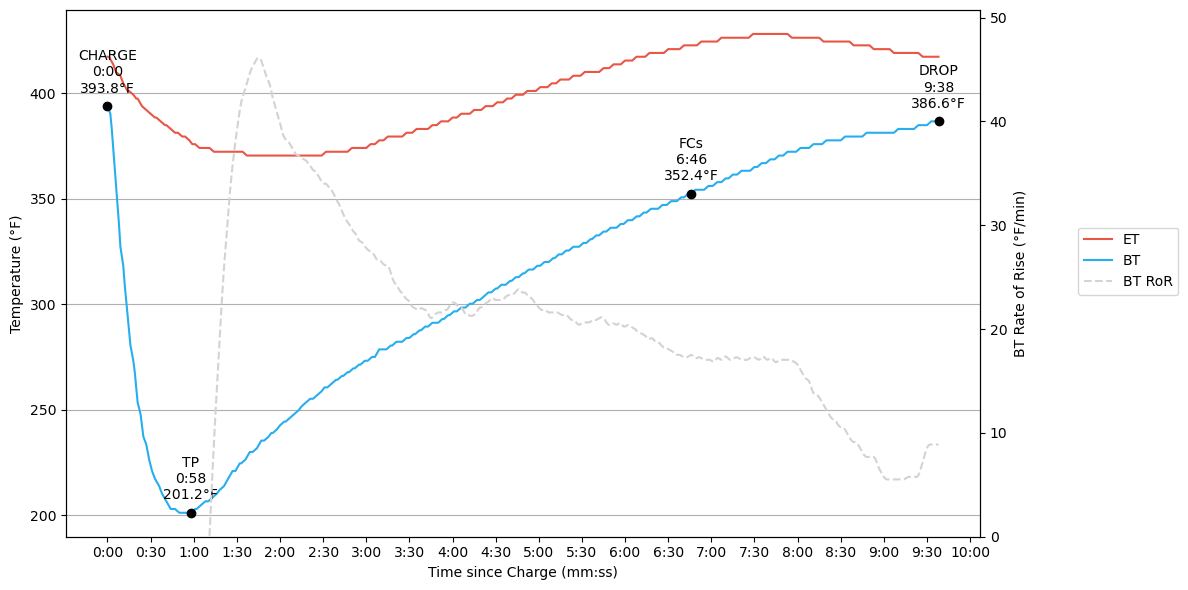

In [8]:
def plot_segmented_roast(df, row_idx=0):
    """Plot segmented ET, BT, BT‐RoR with correctly placed event markers."""
    row     = df.iloc[row_idx]
    # relative times for the segment
    t_abs   = row["time_seg"]
    charge  = row["charge_time"]
    t       = [tt - charge for tt in t_abs]
    et, bt, ror = row["et_seg"], row["bt_seg"], row["ror_seg"]

    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.plot(t, et, color="#ea5545", label="ET")
    ax1.plot(t, bt, color="#27aeef", label="BT")

    # events at offsets from charge
    events = [
        ("CHARGE", 0),
        ("TP",      row["tp_time"]),
        ("FCs",     row["fcs_time"]),
        ("DROP",    row["drop_time"])
    ]
    for name, rel in events:
        # find index in t where time >= rel
        idx = next(i for i, x in enumerate(t) if x >= rel)
        x, y = t[idx], bt[idx]
        ax1.scatter(x, y, color="black", zorder=5)
        ax1.text(
            x, y + 5,
            f"{name}\n{int(x//60)}:{int(x%60):02d}\n{y:.1f}°F",
            ha="center", va="bottom"
        )

    # BT‐RoR from TP onward
    tp_rel = row["tp_time"]
    tp_i   = next(i for i, x in enumerate(t) if x >= tp_rel)
    ax2    = ax1.twinx()
    ax2.plot(t[tp_i:], ror[tp_i:], "--", color="lightgray", label="BT RoR")
    ax2.set_ylabel("BT Rate of Rise (°F/min)")
    ax2.set_ylim(0, max(ror)*1.1)

    # formatting
    ax1.xaxis.set_major_locator(MultipleLocator(30))
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x//60)}:{int(x%60):02d}"))
    ax1.set_xlabel("Time since Charge (mm:ss)")
    ax1.set_ylabel("Temperature (°F)")
    ax1.grid(True, axis="y")

    # combined legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left", bbox_to_anchor=(1.1, .6))

    plt.tight_layout()
    plt.show()

# Example usage:
plot_segmented_roast(sliced, row_idx=0)


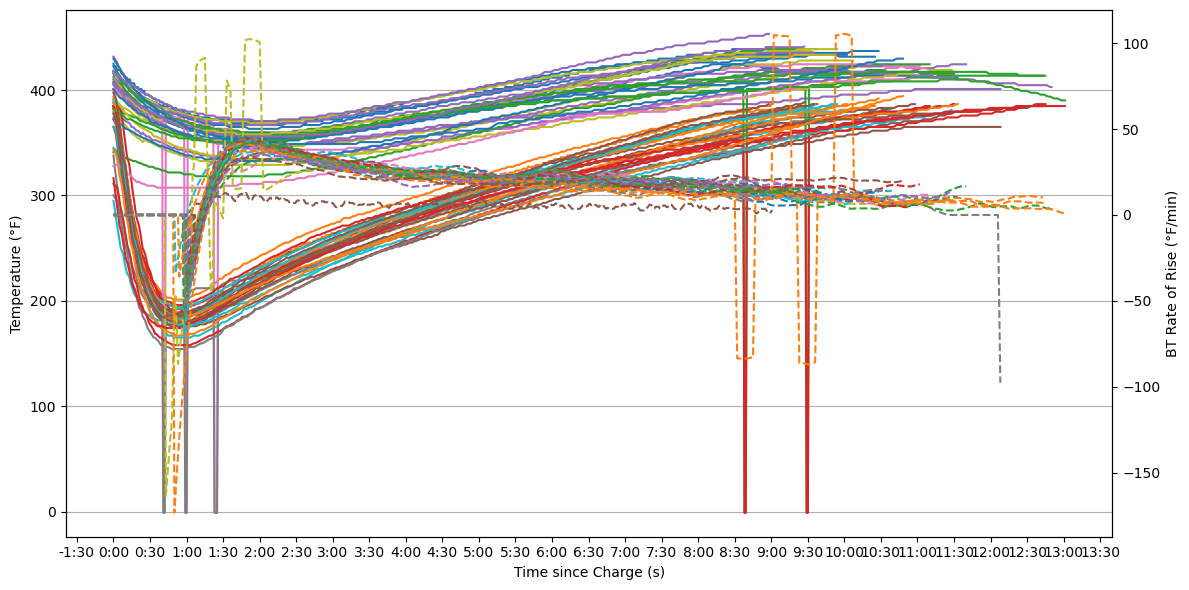

In [9]:
def plot_all_segmented_roasts(df):
    """Plot segmented ET, BT and BT‐RoR for all roasts on a single figure."""
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    # plot each roast
    for _, row in df.iterrows():
        # time since charge
        t = [tt - row["charge_time"] for tt in row["time_seg"]]
        ax1.plot(t, row["et_seg"], label=f"{row['filename']} ET")
        ax1.plot(t, row["bt_seg"], label=f"{row['filename']} BT")
        # BT‐RoR
        ax2.plot(t, row["ror_seg"], "--", label=f"{row['filename']} RoR")
    # axis labels and formatting
    ax1.set_xlabel("Time since Charge (s)")
    ax1.set_ylabel("Temperature (°F)")
    ax2.set_ylabel("BT Rate of Rise (°F/min)")
    ax1.xaxis.set_major_locator(MultipleLocator(30))
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x//60)}:{int(x%60):02d}"))
    ax1.grid(True, axis="y")
    # combined legend
    # h1, l1 = ax1.get_legend_handles_labels()
    # h2, l2 = ax2.get_legend_handles_labels()
    # ax1.legend(h1 + h2, l1 + l2, loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

# usage
plot_all_segmented_roasts(sliced)


In [10]:
def annotate_roast_events(df):
    """Compute charge_time, event observed times, OK flags, and temp diffs for TP, FCs, and DROP."""
    def _process(row):
        # find charge_time
        idx_c = next((i for i, (e, b) in enumerate(zip(row["et"], row["bt"])) 
                      if e == row["charge_et"] and b == row["charge_bt"]), None)
        charge_time = row["time"][idx_c] if idx_c is not None else None
        if charge_time is None:
            warnings.warn(f"No charge match in {row.get('filename','row')}")
        
        result = {"charge_time": charge_time}
        # for each event, calculate observed time, OK flags, and diffs
        for evt in ("tp", "fcs", "drop"):
            abs_t = (charge_time or 0) + row.get(f"{evt}_time", 0)
            idx_e = next((i for i, t in enumerate(row["time"]) if t >= abs_t), None)
            if idx_e is None:
                warnings.warn(f"{evt.upper()} not found in {row.get('filename','row')}")
                # defaults if missing
                result.update({
                    f"{evt}_time_obs": None,
                    f"{evt}_et_ok":    False,
                    f"{evt}_bt_ok":    False,
                    f"{evt}_et_diff":  None,
                    f"{evt}_bt_diff":  None,
                })
            else:
                obs_et = row["et"][idx_e]
                obs_bt = row["bt"][idx_e]
                exp_et = row[f"{evt}_et"]
                exp_bt = row[f"{evt}_bt"]
                result.update({
                    f"{evt}_time_obs": row["time"][idx_e],
                    f"{evt}_et_ok":    obs_et == exp_et,
                    f"{evt}_bt_ok":    obs_bt == exp_bt,
                    f"{evt}_et_diff":  obs_et - exp_et,
                    f"{evt}_bt_diff":  obs_bt - exp_bt,
                })
        return pd.Series(result)
    
    return pd.concat([df, df.apply(_process, axis=1)], axis=1)

# Example usage:
# annotated = annotate_roast_events(roast_data)


annotate = annotate_roast_events(roast_data)

# print filename, charge time, drop time (absolute), and duration for each roast
for _, r in annotate.iterrows():
    drop_abs = r.charge_time + r.drop_time
    print(f"{r.filename}: charge at {r.charge_time}, drop at {drop_abs}, duration {r.drop_time}")


24-11-16_1129: charge at 1259.5620098338, drop at 1837.5620098338, duration 578.0
20-08-07_2030: charge at nan, drop at nan, duration 584.0
20-05-16_1121-mill-city-rsc-batch-1: charge at nan, drop at nan, duration 672.0
20-04-25_2112-mill-city-colombia-rsc-batch-3: charge at nan, drop at nan, duration 748.0
Ethiopian - 200g - Charge 280 Roast 2: charge at nan, drop at nan, duration 714.0
batch1_24-11-23_1244: charge at 338.4956906252, drop at 879.1956906252001, duration 540.7
20-08-25_2136: charge at nan, drop at nan, duration 596.0
20-07-12_2116: charge at nan, drop at nan, duration 654.0
20-04-12_2138-6th-manual-failure: charge at nan, drop at nan, duration 588.0
25-02-05_1149: charge at 206.209906833, drop at 844.209906833, duration 638.0
20-04-17_1737: charge at nan, drop at nan, duration 716.0
Columbia Sierra Nevada - 250g  -Roast 3: charge at nan, drop at nan, duration 693.0
20-06-20_1055-colombia-fto-fem-200g-batch-1: charge at nan, drop at nan, duration 662.0
20-04-30_2148-mill

/var/folders/8y/ph09xyts1mlc3d_jm8zbpqqh0000gn/T/ipykernel_2782/2557826477.py:9: UserWarning: No charge match in 20-08-07_2030
  warnings.warn(f"No charge match in {row.get('filename','row')}")
/var/folders/8y/ph09xyts1mlc3d_jm8zbpqqh0000gn/T/ipykernel_2782/2557826477.py:9: UserWarning: No charge match in 20-05-16_1121-mill-city-rsc-batch-1
  warnings.warn(f"No charge match in {row.get('filename','row')}")
/var/folders/8y/ph09xyts1mlc3d_jm8zbpqqh0000gn/T/ipykernel_2782/2557826477.py:9: UserWarning: No charge match in 20-04-25_2112-mill-city-colombia-rsc-batch-3
  warnings.warn(f"No charge match in {row.get('filename','row')}")
/var/folders/8y/ph09xyts1mlc3d_jm8zbpqqh0000gn/T/ipykernel_2782/2557826477.py:9: UserWarning: No charge match in Ethiopian - 200g - Charge 280 Roast 2
  warnings.warn(f"No charge match in {row.get('filename','row')}")
/var/folders/8y/ph09xyts1mlc3d_jm8zbpqqh0000gn/T/ipykernel_2782/2557826477.py:9: UserWarning: No charge match in 20-08-25_2136
  warnings.warn(f"No

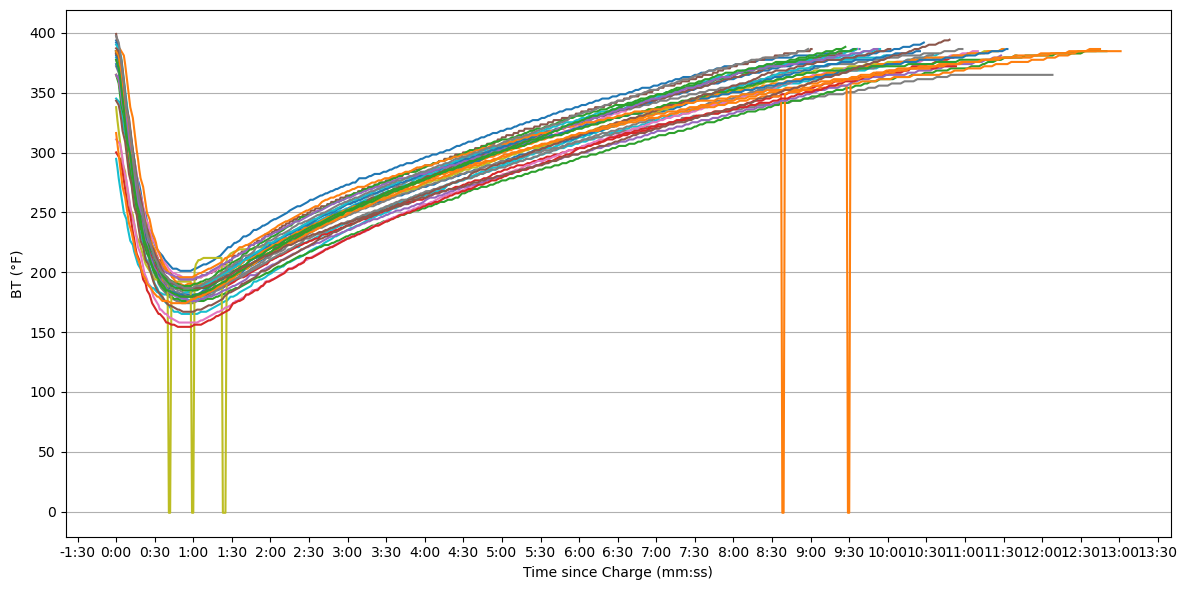

In [11]:
def plot_all_bt_segments(df):
    """Plot BT segments for all roasts on a single axes."""
    fig, ax = plt.subplots(figsize=(12,6))
    for _, row in df.iterrows():
        t = [tt - row["charge_time"] for tt in row["time_seg"]]
        ax.plot(t, row["bt_seg"], label=row["filename"])
    ax.set_xlabel("Time since Charge (mm:ss)")
    ax.set_ylabel("BT (°F)")
    ax.xaxis.set_major_locator(MultipleLocator(30))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x//60)}:{int(x%60):02d}"))
    # ax.legend(loc="upper left", bbox_to_anchor=(1.05,1))
    ax.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

# usage
plot_all_bt_segments(sliced)


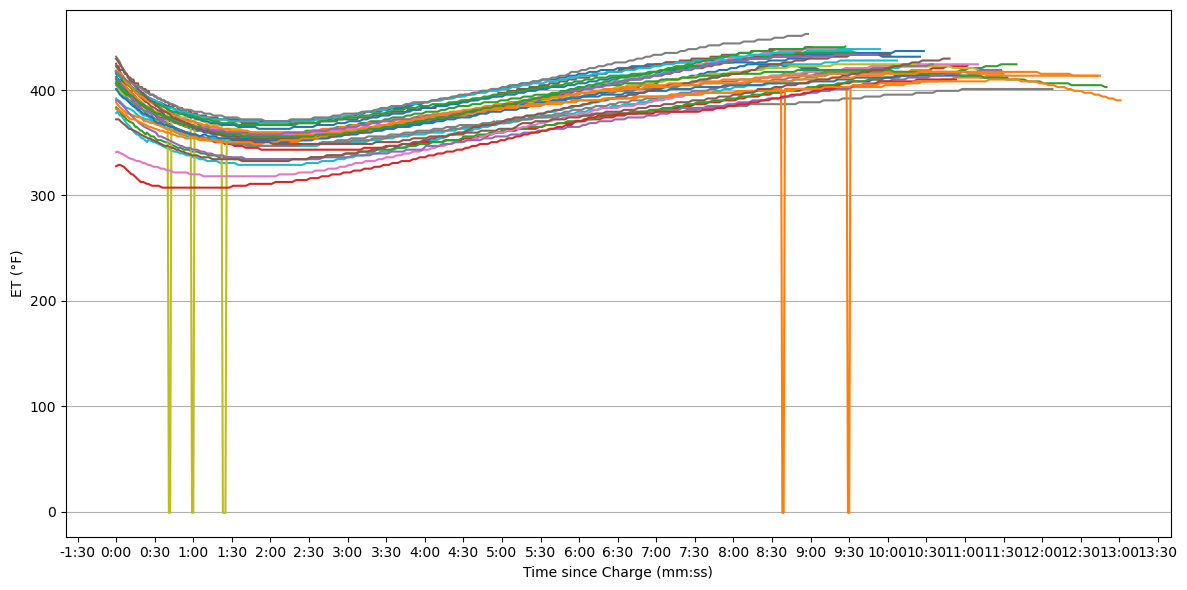

In [12]:
def plot_all_et_segments(df):
    """Plot BT segments for all roasts on a single axes."""
    fig, ax = plt.subplots(figsize=(12,6))
    for _, row in df.iterrows():
        t = [tt - row["charge_time"] for tt in row["time_seg"]]
        ax.plot(t, row["et_seg"], label=row["filename"])
    ax.set_xlabel("Time since Charge (mm:ss)")
    ax.set_ylabel("ET (°F)")
    ax.xaxis.set_major_locator(MultipleLocator(30))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x//60)}:{int(x%60):02d}"))
    # ax.legend(loc="upper left", bbox_to_anchor=(1.05,1))
    ax.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

# usage
plot_all_et_segments(sliced)


In [13]:
def hampel_filter(bt, window_size=10, n_sigmas=3):
    """Remove spike outliers from a 1D array via Hampel filter."""
    bt = np.asarray(bt)
    new_bt = bt.copy()
    k = window_size
    L = len(bt)
    for i in range(L):
        start = max(i - k, 0)
        end = min(i + k, L-1)
        window = bt[start:end+1]
        med = np.median(window)
        mad = np.mean(np.abs(window - med))
        threshold = n_sigmas * 1.4826 * mad
        if abs(bt[i] - med) > threshold:
            new_bt[i] = med
    return new_bt
def clean_segments_and_recalc_ror(df, window=30, smooth_size=15):
    df2 = df.copy()
    def _process(row):
        bt = np.array(row["bt_seg"])
        et = np.array(row["et_seg"])
        bt_clean = hampel_filter(bt)
        et_clean = hampel_filter(et)
        ror = np.zeros(len(bt_clean))
        for i in range(window, len(bt_clean)):
            ror[i] = (bt_clean[i] - bt_clean[i-window]) / window * 60
        ror_sm = uniform_filter1d(ror, size=smooth_size).tolist()
        return pd.Series({
            "bt_seg_clean": bt_clean.tolist(),
            "et_seg_clean": et_clean.tolist(),
            "ror_seg_clean": ror_sm
        })
    df2[["bt_seg_clean", "et_seg_clean", "ror_seg_clean"]] = df2.apply(_process, axis=1)
    return df2

# usage without overwriting original
cleaned = clean_segments_and_recalc_ror(sliced)
# cleaned.head()

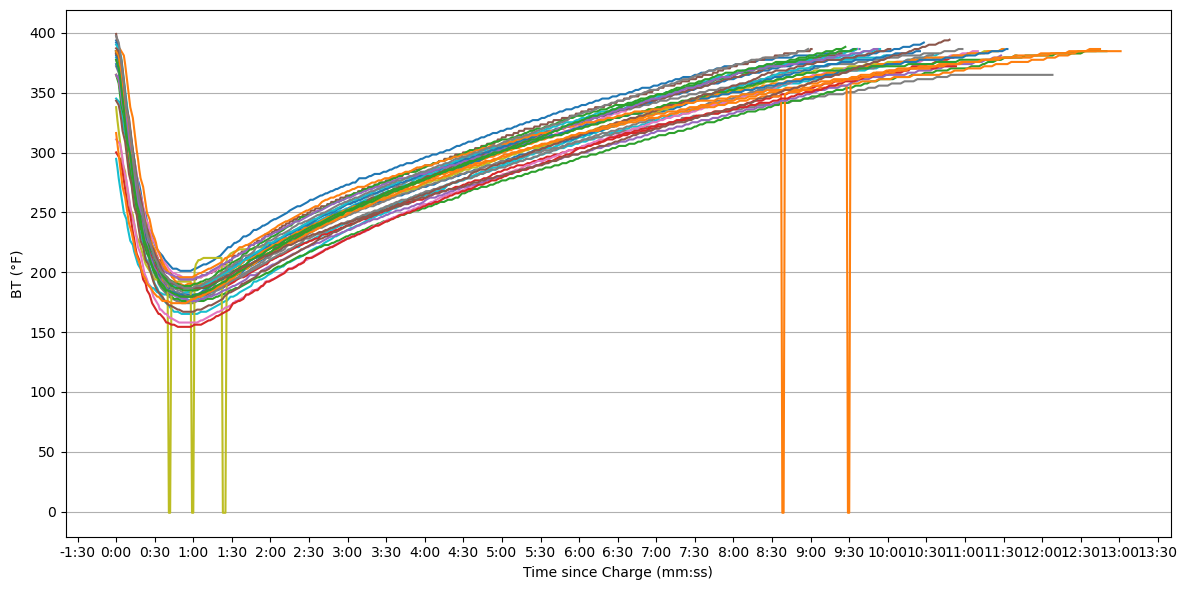

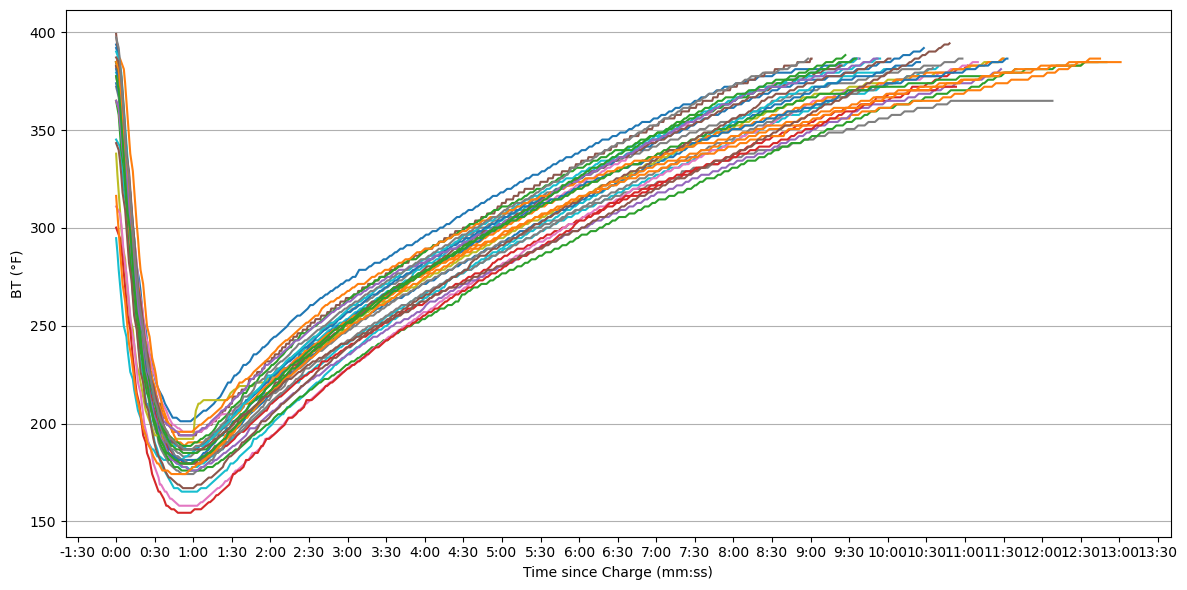

In [14]:
def plot_all_bt_segments_clean(df):
    """Plot BT segments for all roasts on a single axes."""
    fig, ax = plt.subplots(figsize=(12,6))
    for _, row in df.iterrows():
        t = [tt - row["charge_time"] for tt in row["time_seg"]]
        ax.plot(t, row["bt_seg_clean"], label=row["filename"])
    ax.set_xlabel("Time since Charge (mm:ss)")
    ax.set_ylabel("BT (°F)")
    ax.xaxis.set_major_locator(MultipleLocator(30))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x//60)}:{int(x%60):02d}"))
    # ax.legend(loc="upper left", bbox_to_anchor=(1.05,1))
    ax.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

# usage
plot_all_bt_segments(cleaned)
plot_all_bt_segments_clean(cleaned)


In [15]:


def regularize_segments(df, n_points=200):
    """Resample cleaned segments onto a fixed 0→1 grid including a new time_reg column,
       handling empty segments by filling with NaNs."""
    grid = np.linspace(0, 1, n_points).tolist()
    def _interp(row):
        ts_list = row.get("time_seg", []) or []
        if len(ts_list) < 2:
            # not enough points to interpolate
            return pd.Series({
                "time_reg": grid,
                "bt_reg":   [np.nan]*n_points,
                "et_reg":   [np.nan]*n_points,
                "ror_reg":  [np.nan]*n_points
            })
        ts = np.array(ts_list)
        # normalize time to 0→1
        t_norm = (ts - ts[0]) / (ts[-1] - ts[0])
        # perform interpolation
        bt_vals  = np.interp(grid, t_norm, row["bt_seg_clean"])
        et_vals  = np.interp(grid, t_norm, row["et_seg_clean"])
        ror_vals = np.interp(grid, t_norm, row["ror_seg_clean"])
        return pd.Series({
            "time_reg": grid,
            "bt_reg":   bt_vals.tolist(),
            "et_reg":   et_vals.tolist(),
            "ror_reg":  ror_vals.tolist()
        })
    regs = df.apply(_interp, axis=1)
    return pd.concat([df.reset_index(drop=True), regs.reset_index(drop=True)], axis=1)

# usage
regularized = regularize_segments(cleaned, n_points=200)
regularized[["filename","time_reg","bt_reg"]].head()

# usage
regularized = regularize_segments(cleaned, n_points=200)
regularized[["filename","time_reg","bt_reg"]].head()


filename  \
0                                 24-11-16_1129   
1                                 20-08-07_2030   
2           20-05-16_1121-mill-city-rsc-batch-1   
3  20-04-25_2112-mill-city-colombia-rsc-batch-3   
4         Ethiopian - 200g - Charge 280 Roast 2   

                                            time_reg  \
0  [0.0, 0.005025125628140704, 0.0100502512562814...   
1  [0.0, 0.005025125628140704, 0.0100502512562814...   
2  [0.0, 0.005025125628140704, 0.0100502512562814...   
3  [0.0, 0.005025125628140704, 0.0100502512562814...   
4  [0.0, 0.005025125628140704, 0.0100502512562814...   

                                              bt_reg  
0  [393.8, 383.68759650077874, 357.7188565785424,...  
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
2  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
3  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
4  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...

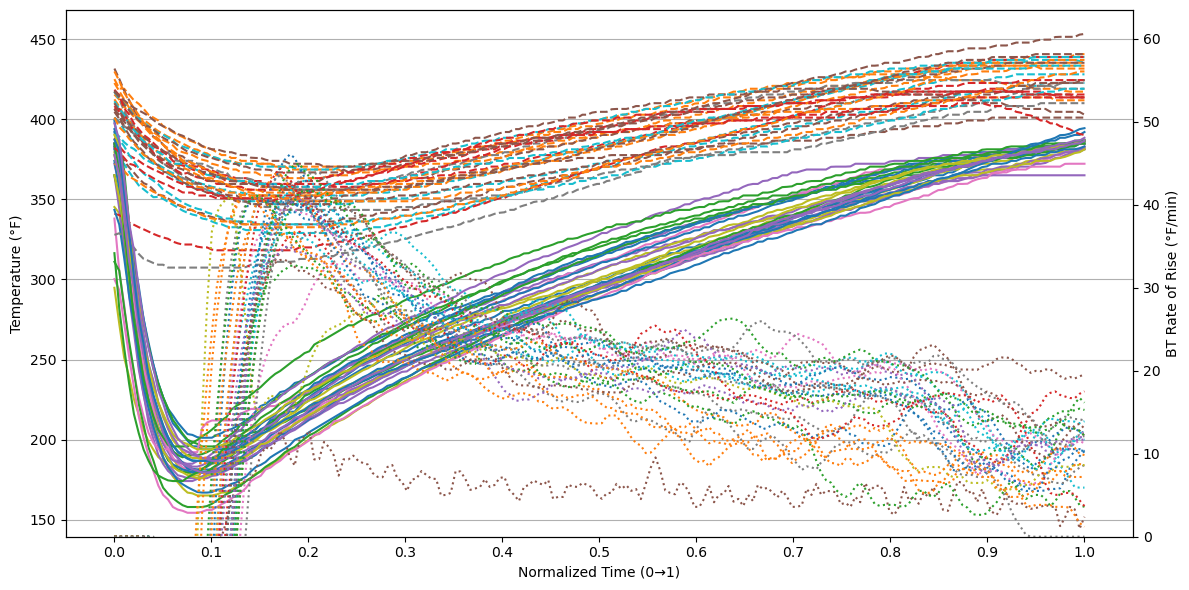

In [16]:

def plot_all_clean_reg(df):
    """Plot normalized ET, BT and BT‐RoR (y-axis for RoR from 0) for all roasts."""
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    for _, row in df.iterrows():
        t = row["time_reg"]
        ax1.plot(t, row["bt_reg"], label=f"{row['filename']} BT")
        ax1.plot(t, row["et_reg"], "--", label=f"{row['filename']} ET")
        ax2.plot(t, row["ror_reg"], ":", label=f"{row['filename']} RoR")
    ax1.set_xlabel("Normalized Time (0→1)")
    ax1.set_ylabel("Temperature (°F)")
    ax2.set_ylabel("BT Rate of Rise (°F/min)")
    ax2.set_ylim(bottom=0)  # ensure RoR axis starts at zero
    ax1.xaxis.set_major_locator(MultipleLocator(0.1))
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.1f}"))
    ax1.grid(True, axis="y")
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    # ax1.legend(h1 + h2, l1 + l2, loc="upper left", bbox_to_anchor=(1.05,1))
    plt.tight_layout()
    plt.show()

# usage
plot_all_clean_reg(regularized)


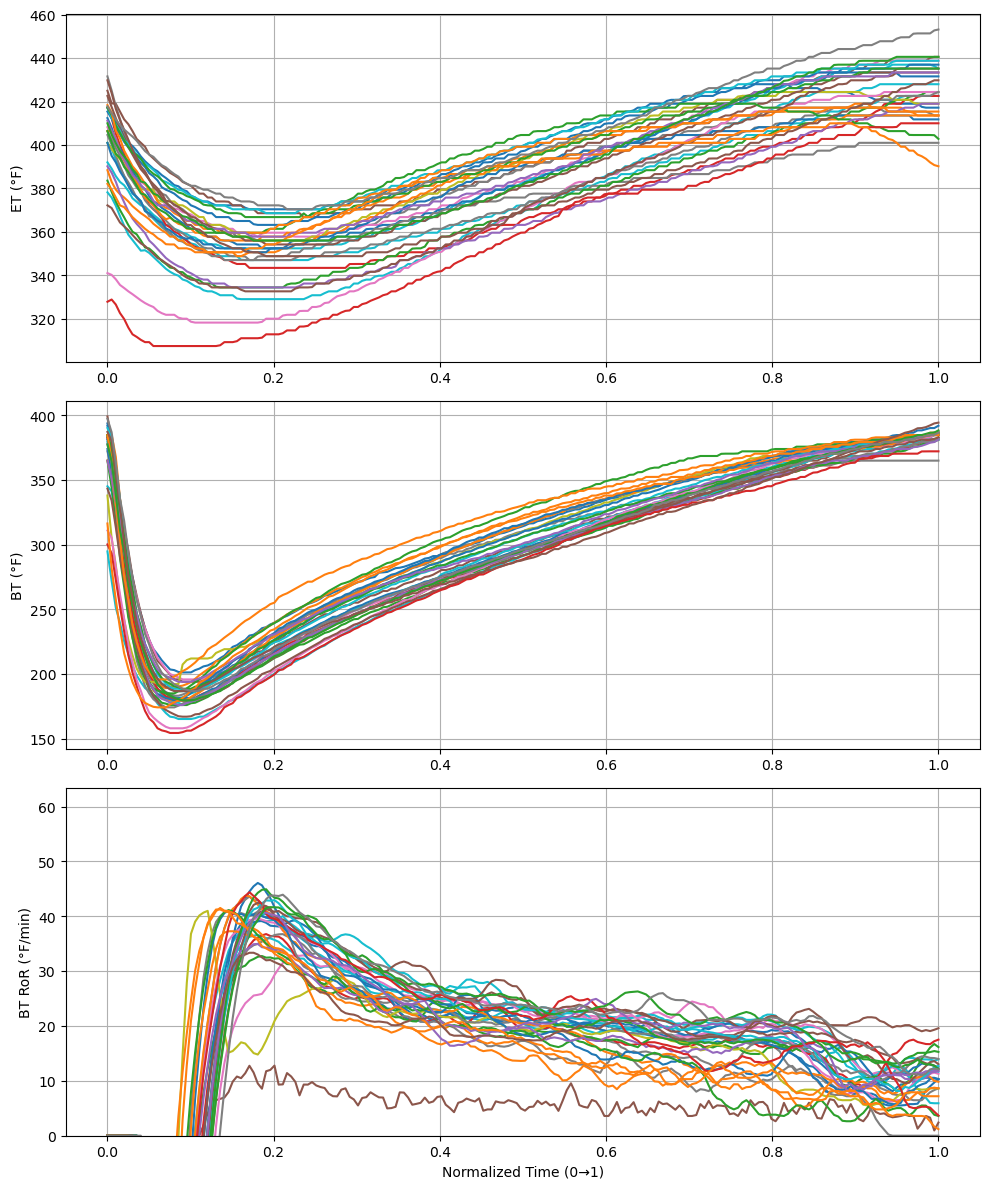

In [25]:

def plot_all_clean_reg_separate(df):
    """Plot normalized ET, BT, and BT‐RoR on three separate panels."""
    t = df.iloc[0]["time_reg"]
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))
    # ET plot
    for _, row in df.iterrows():
        axes[0].plot(t, row["et_reg"], label=row["filename"])
    axes[0].set_ylabel("ET (°F)")
    axes[0].grid(True)
    #axes[0].legend()
    # BT plot
    for _, row in df.iterrows():
        axes[1].plot(t, row["bt_reg"], label=row["filename"])
    axes[1].set_ylabel("BT (°F)")
    axes[1].grid(True)
    #axes[1].legend()
    # RoR plot
    for _, row in df.iterrows():
        axes[2].plot(t, row["ror_reg"], label=row["filename"])
    axes[2].set_ylabel("BT RoR (°F/min)")
    axes[2].set_xlabel("Normalized Time (0→1)")
    axes[2].grid(True)
    axes[2].set_ylim(bottom=0)  # ensure RoR axis starts at zero

    #axes[2].legend()
    plt.tight_layout()
    plt.show()
    
plot_all_clean_reg_separate(regularized)

In [26]:
def score_ror_from_df(df):
    """Compute roast scores from normalized BT‐RoR (`ror_reg`) in a DataFrame."""
    records = []
    for _, row in df.iterrows():
        filename = row["filename"]
        ror = np.array(row["ror_reg"])
        if ror.size:
            peak_value      = float(np.max(ror))
            diffs           = np.diff(ror)
            decline_ratio   = float(np.sum(diffs > 0) / ror.size)
            flick_magnitude = float(np.max(np.diff(ror[-30:]))) if ror.size >= 30 else 0.0
        else:
            peak_value = np.nan
            decline_ratio = np.nan
            flick_magnitude = 0.0
        score = 100.0
        if not np.isnan(decline_ratio):
            score -= decline_ratio * 50
        score -= max(0, flick_magnitude - 0.5) * 30
        score -= max(0, peak_value - 40) * 0.5
        score = round(max(0, min(100, score)), 1)
        records.append({
            "file":            filename,
            "score":           score,
            "peak_ror":        round(peak_value, 2),
            "decline_pct":     round(decline_ratio * 100, 2) if not np.isnan(decline_ratio) else np.nan,
            "flick_magnitude": round(flick_magnitude, 2)
        })
    return pd.DataFrame(records)

# Assuming your regularized DataFrame is named `regularized`:
scores_df = score_ror_from_df(regularized)
print(scores_df)


                                                  file  score  peak_ror  \
0                                        24-11-16_1129   53.3     46.09   
1                                        20-08-07_2030  100.0       NaN   
2                  20-05-16_1121-mill-city-rsc-batch-1  100.0       NaN   
3         20-04-25_2112-mill-city-colombia-rsc-batch-3  100.0       NaN   
4                Ethiopian - 200g - Charge 280 Roast 2  100.0       NaN   
..                                                 ...    ...       ...   
191                                      20-09-28_2134  100.0       NaN   
192           20-05-13_2241-mill-city-rsc-batch-1-good  100.0       NaN   
193  Guatamala 20-04-12_1243 - 140g Roast 2 - Bean ...  100.0       NaN   
194                                      20-07-21_2030  100.0       NaN   
195                                      20-11-24_2046  100.0       NaN   

     decline_pct  flick_magnitude  
0           35.0             1.37  
1            0.0           

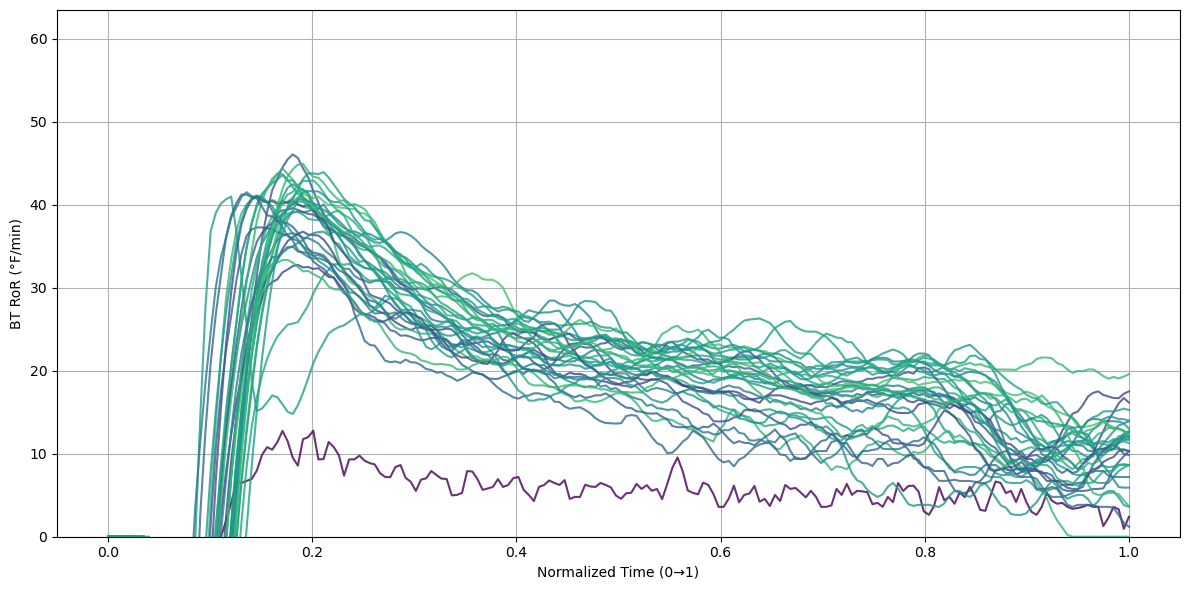

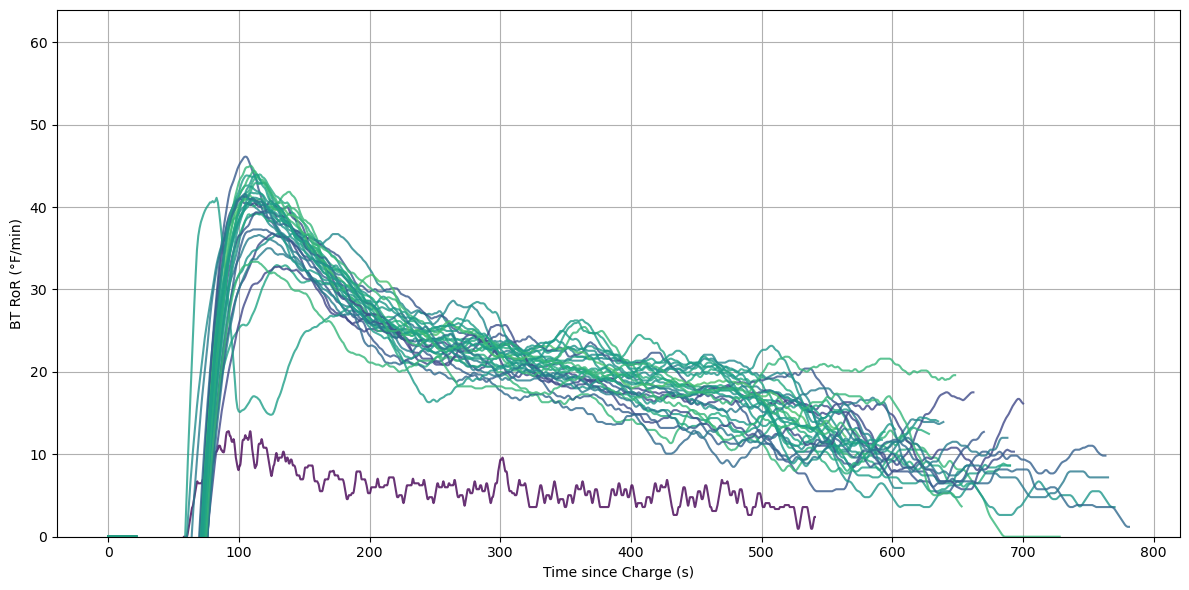

In [32]:
from matplotlib.colors import Normalize

# merge scores with regularized data
df_plot = regularized.merge(scores_df, left_on='filename', right_on='file')

norm = Normalize(vmin=df_plot['score'].min(), vmax=df_plot['score'].max())
cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot 1: normalized ROR colored by score
fig, ax = plt.subplots(figsize=(12, 6))
for _, row in df_plot.iterrows():
    ax.plot(row['time_reg'], row['ror_reg'], color=cmap(norm(row['score'])), alpha=0.8)
ax.set_xlabel('Normalized Time (0→1)')
ax.set_ylabel('BT RoR (°F/min)')
ax.set_ylim(bottom=0)
# ax.colorbar(sm, label='Score')
ax.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: cleaned ROR segments colored by score
fig, ax = plt.subplots(figsize=(12, 6))
for _, row in df_plot.iterrows():
    t_seg = np.array(row['time_seg']) - row['charge_time']
    ax.plot(t_seg, row['ror_seg_clean'], color=cmap(norm(row['score'])), alpha=0.8)
ax.set_xlabel('Time since Charge (s)')
ax.set_ylabel('BT RoR (°F/min)')
ax.set_ylim(bottom=0)
# ax.colorbar(sm, label='Score')
ax.grid(True)
plt.tight_layout()
plt.show()


/var/folders/8y/ph09xyts1mlc3d_jm8zbpqqh0000gn/T/ipykernel_2782/1856851334.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


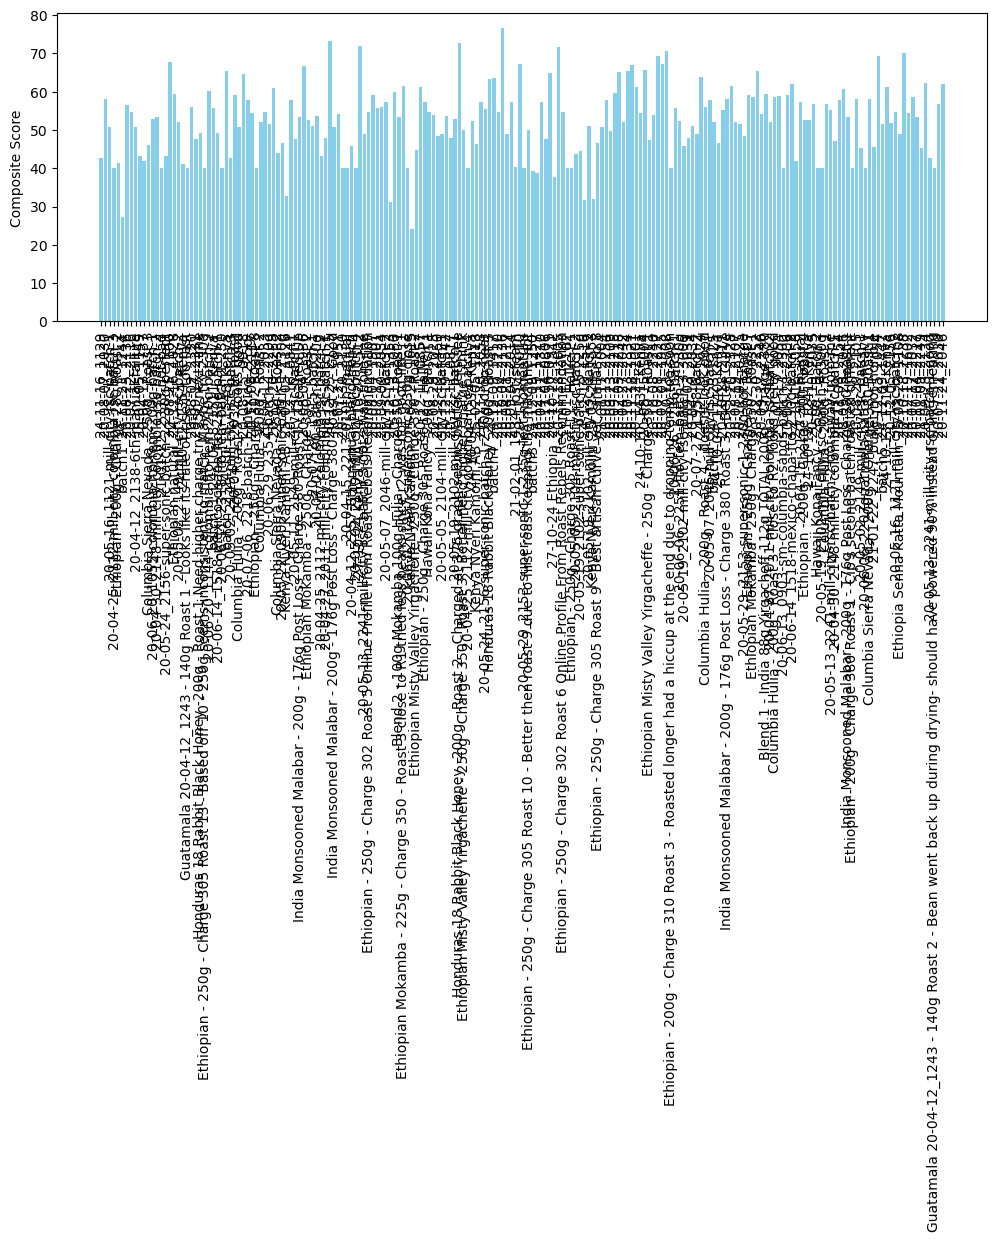

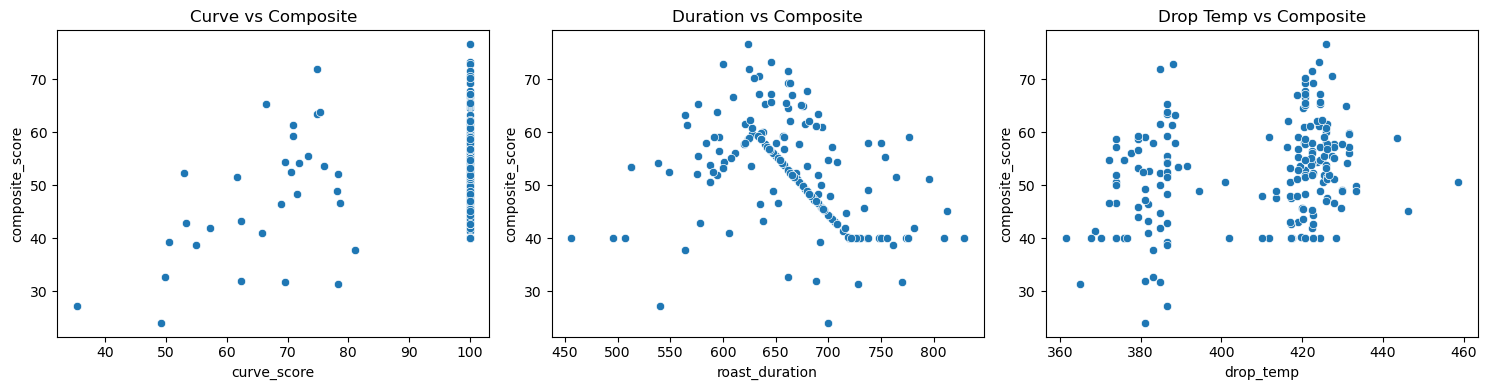

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# composite scoring function
def score_roast(curve_score, roast_duration, drop_temp, dev_pct):
    curve_score = min(curve_score, 100)
    c_comp = curve_score * 0.4
    d_pen  = abs(roast_duration - 630) / 90
    d_score= max(0, 20 * (1 - d_pen))
    dr_pen = abs(drop_temp - 388) / 4
    dr_score = max(0, 20 * (1 - dr_pen))
    dev_pen= abs(dev_pct - 22.5) / 2.5
    dev_score= max(0, 20 * (1 - dev_pen))
    return round(max(0, min(100, c_comp + d_score + dr_score + dev_score)), 1)

# apply to DataFrame
def compute_composite_scores(df):
    def _row(r):
        ror = np.array(r["ror_reg"])
        pv  = ror.max() if ror.size else 0
        cr  = max(0, min(100, round(100 - np.sum(np.diff(ror)>0)/ror.size*50 \
                - max(0, np.max(np.diff(ror[-30:]))-0.5)*30 \
                - max(0, pv-40)*0.5,1))) if ror.size else 0
        dur = r["drop_time"]
        drop_temp = r["drop_bt"]
        dev_pct = (r["drop_time"] - r["fcs_time"]) / r["drop_time"] * 100
        comp = score_roast(cr, dur, drop_temp, dev_pct)
        return pd.Series({
            "curve_score": cr,
            "roast_duration": dur,
            "drop_temp": drop_temp,
            "dev_pct": round(dev_pct,1),
            "composite_score": comp
        })
    return df.join(df.apply(_row, axis=1))

scores_df = compute_composite_scores(regularized)

# bar plot
plt.figure(figsize=(12,4))
plt.bar(scores_df["filename"], scores_df["composite_score"], color="skyblue")
plt.xticks(rotation=90)
plt.ylabel("Composite Score")
plt.tight_layout()
plt.show()

# scatter panels
fig, axes = plt.subplots(1,3,figsize=(15,4))
sns.scatterplot(data=scores_df, x="curve_score",    y="composite_score", ax=axes[0]).set_title("Curve vs Composite")
sns.scatterplot(data=scores_df, x="roast_duration", y="composite_score", ax=axes[1]).set_title("Duration vs Composite")
sns.scatterplot(data=scores_df, x="drop_temp",      y="composite_score", ax=axes[2]).set_title("Drop Temp vs Composite")
plt.tight_layout()
plt.show()
